Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2$.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

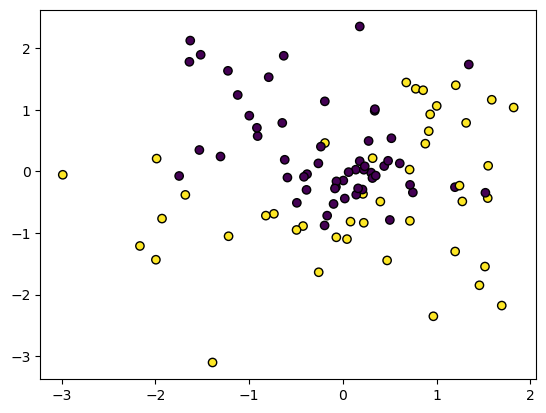

In [37]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [38]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [39]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [40]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """
    # The log joint probability p(y, w | Phi, sigma) is the sum of the log-likelihood p(y | w, Phi) and log-pior p(w | sigma)
    # We first caclculate the log likelihood. The values of y_hat are obtained by calling the predict_probs_MAP function:
    y_hat = predict_probs_MAP(Phi, w)

    # The log likelihood is obatined by using the Bernoulli distribution equation
    # The very small constant 1e-9 was added inside the logarithms to prevent numerical instability (taking the logarithm of zero)
    log_likelihood = torch.sum(y * torch.log(y_hat + 1e-9) + (1 - y) * torch.log(1 - y_hat + 1e-9))
    
    # We then compute the log-prior for a Gaussian prior on the weights
    # D is the dimensionality of w, i.e. the number of features
    D = w.size(0)
    # And the log-prior is found using the Normal distribution equation
    sigma_squared = torch.tensor(sigma ** 2)  
    log_prior = -0.5 * torch.sum(w ** 2) / sigma_squared - 0.5 * D * torch.log(2 * torch.pi * sigma_squared)
    
    # The log-joint probability is finally obtained by adding the log-likelihood and log-prior together
    log_joint = log_likelihood + log_prior
    
    return log_joint


In [41]:
# (GRADING)

In [42]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [43]:
def find_MAP(Phi, y, sigma=10, learning_rate=0.01, num_iterations=1000):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones

    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """
    
    # This function computes the MAP estimate of the weight vector w by maximizing the log joint probability
    # First, we want to initialise the weight vector w as a tensor of zeros with shape (D,)
    w = torch.zeros(Phi.shape[1], requires_grad=True)

    # The losses list is initialised to store the loss value at each iteration of the optimization loop
    losses = []

    # We choose stochastic gradient descent from torch.optim as the optimiser, 
    # It takes for arguments the list of paramneters to optimise and the step size
    optimizer = torch.optim.SGD([w], lr=learning_rate)

    # Start of the gradient descent optimization loop
    for i in range(num_iterations):
        # Set the gradients to 0, to cleat the old gradients from the last step
        optimizer.zero_grad() 
        
        # Compute the log-joint probability given the current weights
        log_joint_prob = log_joint(Phi, y, w, sigma)

        # We define the loss at the negative log-joint probability, to make the problem into a minimisation problem
        loss = -log_joint_prob
        
        # We then compute the gradients of the loss with respect to the weights,
        loss.backward() 
        
        # perform a step of gradient descent,
        optimizer.step()
        
        # and store the loss value in the losses list 
        losses.append(loss.item())

    return w.detach(), losses


### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

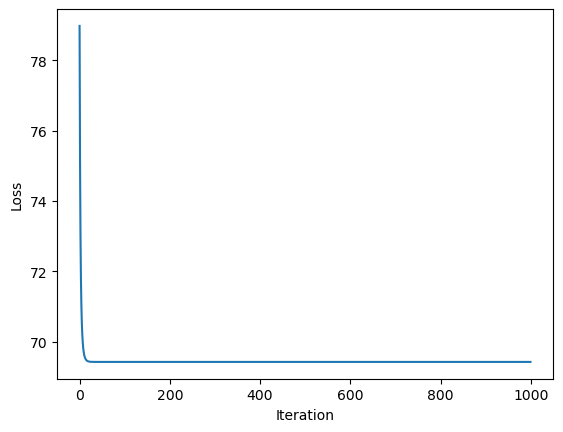

In [44]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

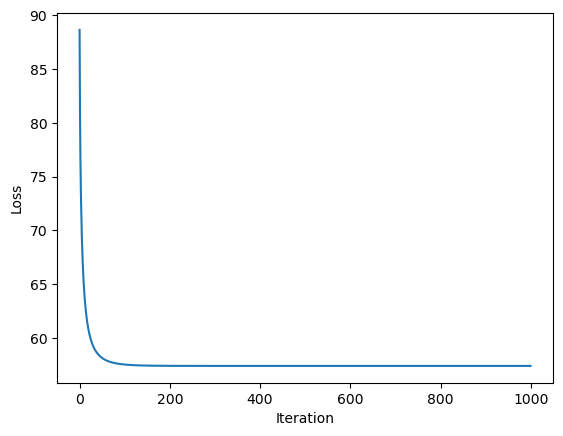

In [45]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [46]:
# (GRADING)

In [47]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [48]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


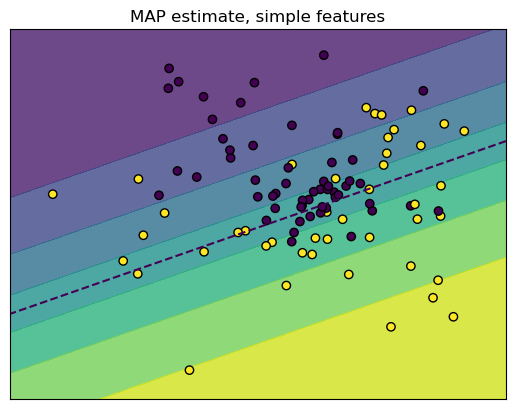

In [49]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


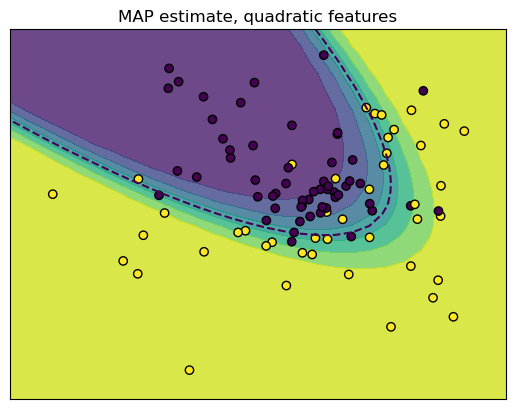

In [50]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [51]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.

    INPUT:
    Phi       : (N, D) tensor of input features
    y         : (N,) tensor of targets (0 or 1)
    w_MAP     : (D,) tensor of MAP-estimated weights
    prior_std : scalar, standard deviation of the Gaussian prior

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    # We obtain the number of observations N and the number of features D from the feature matrix
    N, D = Phi.shape

    # We compute the predicted probabilities using the logistic function at the MAP estimate (w_MAP)
    p = predict_probs_MAP(Phi, w_MAP)  

    # We compute the diagonal weights W_n = p_n * (1 - p_n), which we will need for the Hessian matrix
    W = p * (1 - p)  

    # We can start to construct the Hessian matrix
    # Since W is diagonal, we can multiply Phi by sqrt(W) efficiently
    # We take the square root of W such that we get the correct equation when calculating the Hessian matrix 
    # We use the unsqueeze method to add a dimension (go from (N,) to (N, 1)), we do this to such that we can do element-wise multiplication with Phi
    sqrt_W = torch.sqrt(W).unsqueeze(1)  
    # We perform the element-wise multiplication to obtain Phi_W with shape (N, D)
    Phi_W = Phi * sqrt_W  

    # We compute the Hessian H = Phi_W^T * Phi_W + (1 / prior_std^2) * I (Here the sqrt(W) are multiplied together to get W in the equation for the Hessian)
    H = Phi_W.T @ Phi_W
    H += (1 / prior_std**2) * torch.eye(D)

    # Finally, we compute the covariance matrix as the inverse of Hessian matrix 
    Cov = torch.inverse(H)

    return Cov

In [52]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)

    INPUT:
    Phi   : (N, D) tensor of input features
    w_MAP : (D,) tensor of MAP-estimated weights
    Cov   : (D, D) approximate posterior covariance matrix

    OUTPUT:
    y_hat : (N,) tensor of predicted probabilities p(y=1 | Phi)
    """
    # We build the multivariate normal distribution
    # First we compute the linear term: Phi @ w_MAP
    linear_term = Phi @ w_MAP 

    # Then we compute the variance term v_n = Phi_n^T Cov Phi_n for each data point
    # We can do this pretty efficiently using batch operations
    variance = torch.sum((Phi @ Cov) * Phi, dim=1) 

    # Compute the scaling factor for each data point
    scaling_factor = torch.sqrt(1 + (torch.pi / 8) * variance)

    # Adjust the linear term
    adjusted_linear_term = linear_term / scaling_factor 

    # Compute the predicted probabilities using the sigmoid function
    y_hat = torch.sigmoid(adjusted_linear_term) 

    return y_hat


### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [53]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

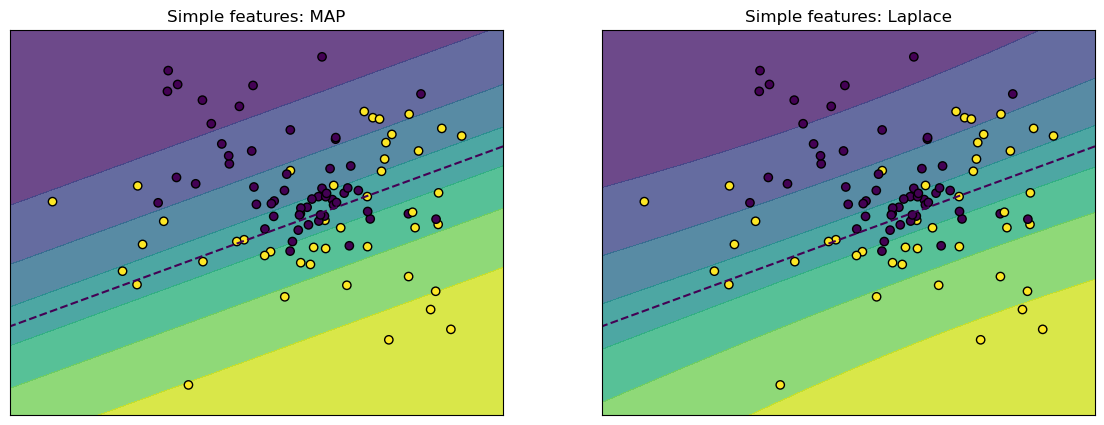

In [54]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [55]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

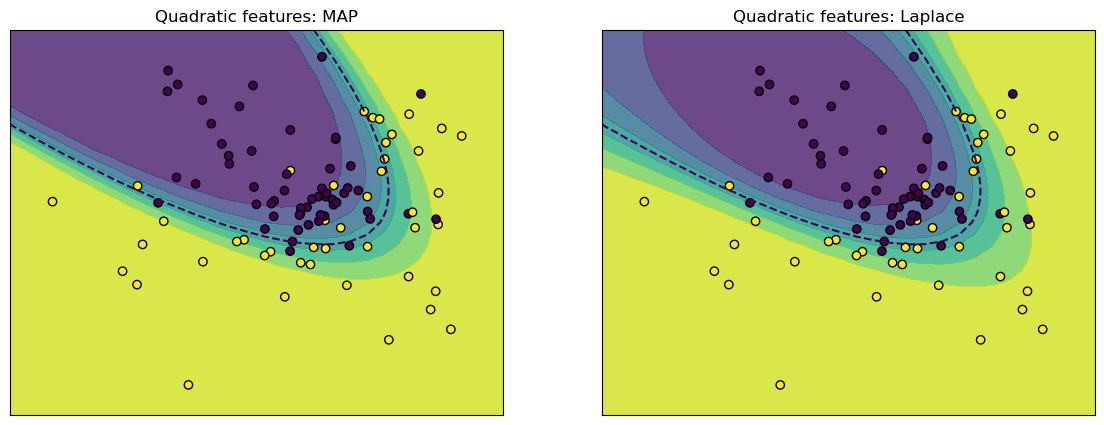

In [56]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [57]:
# (GRADING)

In [58]:
# (GRADING)

In [59]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [60]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    # First, we get the dimensions of the input features 
    N, D = Phi.shape

    # Then we compute the log joint probability 
    log_data_given_w_map = log_joint(Phi, y, w_MAP)

    # We will now use the Occam factor to penalize complexity
    # In essence it allows us to have simpler models to preventing overfitting
    # Its formula is: (2pi)^(D/2) / sqrt(det|Cov|), so its log is: (D/2) * log(2π) - 0.5 * log(det|Cov|)
    # Which we can compute as follows: 
    term_1 = D * torch.log(torch.tensor(2 * torch.pi)) / 2
    term_2 = -0.5 * torch.logdet(Cov)
    occam_factor = term_1 + term_2

    # Finally, we have to combine log joint and Occam factor to get log marginal likelihood 
    log_evidence = log_data_given_w_map + occam_factor
    return log_evidence



In [61]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -62.397377014160156
Model evidence estimate (polynomial features): -46.272804260253906


In [62]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [63]:
def features_student(X):
    """
    We use radial basis functions to make a new feature map

    INPUT:
    X      : (N, 2) tensor of raw input data

    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    # In this function, we are going to copmute the features we will use 
    # and put them all into the Phi variable using the .hstack method. 
    # First we initialize the feature columns with a bias term and original features
    bias = torch.ones((X.shape[0], 1))
    Xm = torch.hstack((bias, X))

    # Then we use radial basis features: we compute two features, corresponding to the distance to the point (1,1)
    #  and the distance to the point (0,0) respectively. These points were found manually, and were altered to increase
    #  test accuracy and model evidence. 
    radial_1 = torch.norm(X - torch.tensor([1.0, 1.0]), dim=1, keepdim=True)
    radial_2 = torch.norm(X, dim=1, keepdim=True)
    
    # We then put all the features together in Phi
    Phi = torch.hstack((Xm, radial_1, radial_2))

    return Phi


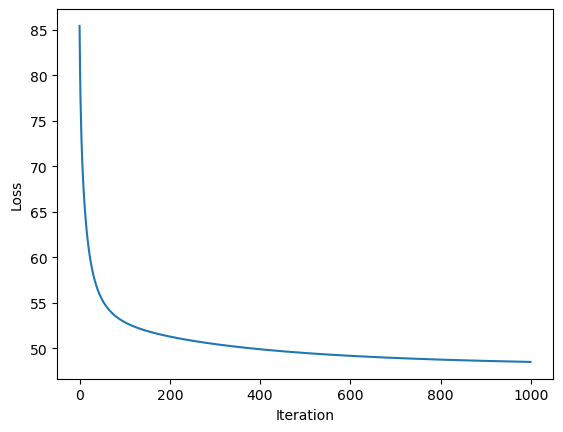

In [64]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [65]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))



YOUR features! Training accuracy = 0.89, test accuracy = 0.90


In [66]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -40.77403259277344


In [67]:
w_MAP_student

tensor([ 2.0726, -1.7181, -4.3760, -4.6692,  5.1029])

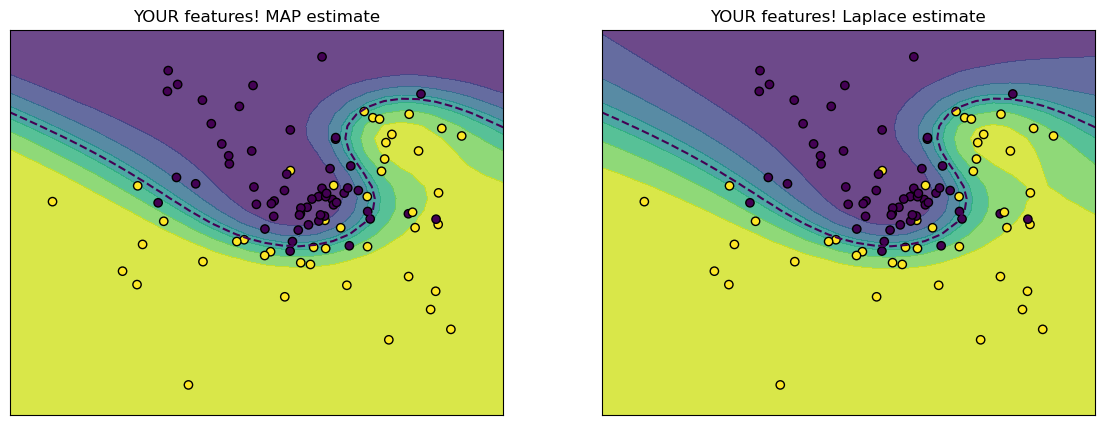

In [68]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

### Question 1:
I chose to use radial base functions to make my feature map after attempting many different methods and comparing the results. In essence, the value of a radial basis function only depends on the distance from a central point. Through trial and error, I chose those center points to be $(0,0)$ and $(1,1)$, and implemeted a function of the form:
\
\
$\phi(\| x - c \|)$
\
\
where $\| x - c \|$ is the Euclidean distance between the point $x$ and the center $c$.


I have tested radial basis functions, trigonometric features, sigmoid activation functions and higher order polynomial functions (I've also implemented indicator functions but they were quickly discarded). I've compared the performance of each method with a few criteria. 
\
\
The first is the test accuracy, as it directly measures how well the model generalises to unseen data. A high test accuracy shows that the model is a good fit to the data without overfitting. The radial basis function method achieved the highest test accuracy with a score of 90%, as well as the best with regards to the second criteria I used to evaluate the value of the models: the model's evidence. This is a good way for us to quantify the trade-off between a model that fits to the data well and a model that is simple enough that it can generalise (and doesn't overfit). The model with the highest evidence is considered the best explanation for the observed data, and radial basis features achived approximately -41, which is 10 higher than trigonometric functions (my next best feature). Finally, as a sanity check, I used the graphical representation of the models to make sure that the predictions were sensible and that there were no obvious mistakes.  

### Question 2: 
Yes, I believe overfitting is possible in this setting, but we have made it very unlikely as a few things are put in place to prevent it. One of them is how we computed the model evidence in the compute_laplace_log_evidence function, were the use of thethe Occam factor, which penalises models that have sharp probability peaks in their posterior (which indicates overfitting), pushes towards simpler models that generalise better. In a scenario where we couldn't compute easily compute the evidence, overfitting could happen. 

I haven't naturraly encountered overfitting, but I have tried to make feature maps for overcomplicated models, which performed very poorly. I have for example used very high order polynomial features. However, I haven't encountered a situation where the training accuracy was very high and the test acuracy very low, which is what we would expect for overfitting, and is the primary way I would detect it. Other good methods include looking at the model evidence, if is it very low, it suggests that the model might be overfitting. Another way to checking is by looking at the plots for the MAP estimate for example (when possible), and see whether the majority of the probability mass is distributed around the training data points. 

Overfitting occurs when the posterior distribution puts most of the probability mass around the training data points. At its core, the Laplace approximation is a technique used to approximate the posterior around its mode as a Gaussian. This means it simplifies the posterior, reducing the model's complexity. This can smooth out overly specific parameter configurations and produce a posterior that generalizes better to new data, so I would say it indirectly helps against overfitting. We can see a little of this happening in the plotted MAP estimate above: the Laplace estimate lowers the probability peaks (this is evident when comparing the top right corner of the images) and make the standard deviation greater (we can see this because the line of equal value are further apart in the Laplace approximation graph). 

#### Ignore the following cells. They are used by the grading system.

In [69]:
# (GRADING)

In [70]:
# (GRADING)